<a href="https://colab.research.google.com/github/36thNinja/36thNinja.github.io/blob/master/Gradcam_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt

In [2]:
class GradCAM:
  def explain(self,IMAGE_PATH,model,CLASS_INDEX,layer_name=None,use_guided_grads=True):

    model_input_image_dim = model.layers[0].output_shape[0][1:3]

    if layer_name is None:
      for layer in model.layers:
        if "conv" in layer.name:
          layer_name = layer.name

    if layer_name is None:
      raise ValueError("No Convolution layer found to perform interpretation")

    img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=model_input_image_dim)
    img = tf.keras.preprocessing.image.img_to_array(img)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
      conv_outputs, predictions = grad_model(np.array([img]))
      loss = predictions[:, CLASS_INDEX]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    #Design choice to use guided back prop instead of deconvolution
    guided_grads = grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
      cam += w * output[:, :, i]

    cam = cam.numpy()
    scaledResult = (cam - cam.min()) / (cam.max() - cam.min())
    im = Image.fromarray(np.uint8(scaledResult*255))
    im = im.resize((224,224),Image.BICUBIC)
    result = np.asarray(im)

    cmap = plt.get_cmap('jet')
    rgba_img = cmap(result)
    rgb_img = np.delete(rgba_img, 3, 2)
    
    

    #result = np.resize(cam.numpy(), model_input_image_dim)
    #result = np.maximum(result, 0)

    #scaledResult = (result - result.min()) / (result.max() - result.min())

    #return scaledResult



In [3]:
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

In [4]:
IMAGE_PATH = 'cat.jpg'
#LAYER_NAME = 'block5_conv3'
CAT_CLASS_INDEX = 281

In [5]:
!wget https://upload.wikimedia.org/wikipedia/commons/1/1a/Arthur%2C_the_cat.jpg 
!mv Arthur,_the_cat.jpg cat.jpg

--2020-09-14 20:40:24--  https://upload.wikimedia.org/wikipedia/commons/1/1a/Arthur%2C_the_cat.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2636769 (2.5M) [image/jpeg]
Saving to: ‘Arthur,_the_cat.jpg’

Arthur,_the_cat.jpg 100%[===================>]   2.51M  8.64MB/s    in 0.3s    

2020-09-14 20:40:24 (8.64 MB/s) - ‘Arthur,_the_cat.jpg’ saved [2636769/2636769]



In [6]:
explainer = GradCAM()

In [7]:
result = explainer.explain(IMAGE_PATH,model,CAT_CLASS_INDEX)

In [8]:
type(result)

numpy.ndarray

In [9]:
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224,224))
img = tf.keras.preprocessing.image.img_to_array(img)

In [10]:
type(img)

numpy.ndarray

In [11]:
import matplotlib.pyplot as plt


cmap = plt.get_cmap('jet')

rgba_img = cmap(result)
rgb_img = np.delete(rgba_img, 3, 2)

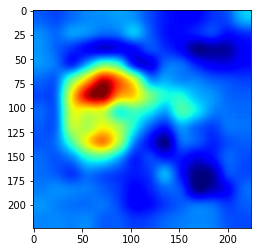

In [13]:
plt.imshow(rgb_img)

In [14]:
np.asarray(rgb_img).shape

(224, 224, 3)

In [23]:
import cv2

cam = cv2.resize(result.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())
cam = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

cv2.imwrite('cam2.png', output_image)

True

In [13]:
img.shape

(224, 224, 3)

In [34]:
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
#result = result.numpy()
scaledResult = (result - result.min()) / (result.max() - result.min())
#im = Image.fromarray(np.uint8(cm.gist_earth(scaledResult)*255))
im = Image.fromarray(np.uint8(scaledResult*255))

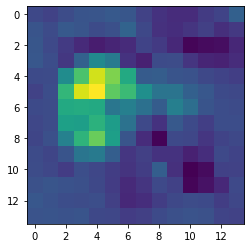

In [35]:
plt.imshow(im)

In [37]:
im = im.resize((224,224),Image.BICUBIC)

In [38]:
np.asarray(im).shape

(224, 224)

In [36]:
im = np.delete(im, 3, 2)

In [40]:
np.asarray(im).shape

(224, 224)

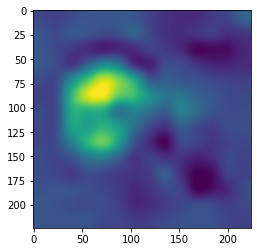

In [39]:
plt.imshow(im)